In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
from pprint import pp
import seaborn as sns

In [2]:
##NEWSPAPERS IDEOLOGY
newspaper_ideo_df = pd.read_csv("news_ideo_over_time.csv", keep_default_na=False)
#newspaper_ideo_df.rename({"published_date": "date"}, inplace=True, axis=1)
print(f'{newspaper_ideo_df["newspaper_ideo"].unique() = }')
print(newspaper_ideo_df.head())

## DEBATES
debates_df = pd.read_csv("speeches_per_date_party.csv", keep_default_na=False)
debates_df = debates_df.replace(    {"current_party": {
            "Centre": "Centre_parties"}})
print(debates_df.shape)
print(debates_df.head())
# check parties
print(f'{debates_df["current_party"].unique() = }')

newspaper_ideo_df["newspaper_ideo"].unique() = array(['Centre', 'Left-wing', 'Right-wing'], dtype=object)
         date newspaper_ideo  POSITIVE  NEGATIVE
0  2021-11-01         Centre         0         1
1  2021-11-01      Left-wing         0         1
2  2021-11-01     Right-wing         1         3
3  2021-11-02         Centre         0         1
4  2021-11-02      Left-wing         1         0
(1431, 4)
         date   current_party  POSITIVE  NEGATIVE
0  2021-11-01  Centre_parties         0         0
1  2021-11-01    Conservative         1         1
2  2021-11-01          Labour         0         0
3  2021-11-02  Centre_parties         0         0
4  2021-11-02    Conservative         1         0
debates_df["current_party"].unique() = array(['Centre_parties', 'Conservative', 'Labour'], dtype=object)


In [3]:
# reshape data to create a column per party/newspaper
## newspapers
newspaper_ideo_pivot = newspaper_ideo_df.pivot_table(
    values=("NEGATIVE", "POSITIVE"),
    index=["date"],
    columns=["newspaper_ideo"],
    aggfunc="sum",
)
# flatten
newspaper_ideo_pivot.columns = newspaper_ideo_pivot.columns.to_flat_index()
newspaper_ideo_pivot.reset_index(inplace=True)

print(newspaper_ideo_pivot.head(2))

## debates
debates_df_pivot = debates_df.pivot_table(
    values=("NEGATIVE", "POSITIVE"),
    index=["date"],
    columns=["current_party"],
    aggfunc="sum",
)
# flatten
debates_df_pivot.columns = debates_df_pivot.columns.to_flat_index()
newspaper_ideo_pivot.reset_index(inplace=True)

print(debates_df_pivot.head(2))


         date  (NEGATIVE, Centre)  (NEGATIVE, Left-wing)  \
0  2021-11-01                   1                      1   
1  2021-11-02                   1                      0   

   (NEGATIVE, Right-wing)  (POSITIVE, Centre)  (POSITIVE, Left-wing)  \
0                       3                   0                      0   
1                       4                   0                      1   

   (POSITIVE, Right-wing)  
0                       1  
1                       0  
            (NEGATIVE, Centre_parties)  (NEGATIVE, Conservative)  \
date                                                               
2021-11-01                           0                         1   
2021-11-02                           0                         0   

            (NEGATIVE, Labour)  (POSITIVE, Centre_parties)  \
date                                                         
2021-11-01                   0                           0   
2021-11-02                   0                           0 

In [4]:
## Joined on the newspaper dataset because lower max date
merged_df = newspaper_ideo_pivot.merge(
    debates_df_pivot, on="date", how="left", suffixes=("_newspapers", "_debates")
)
#fix date as index
#merged_df.set_index("date", inplace=True)
merged_df = merged_df.drop('index', inplace=False, axis=1)

#fix colnames
merged_df.columns = [ "_".join(x) if type(x) == tuple else x for x in merged_df.columns]
print(merged_df.shape)
print(merged_df.head(2))

(477, 13)
         date  NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  \
0  2021-11-01                1                   1                    3   
1  2021-11-02                1                   0                    4   

   POSITIVE_Centre  POSITIVE_Left-wing  POSITIVE_Right-wing  \
0                0                   0                    1   
1                0                   1                    0   

   NEGATIVE_Centre_parties  NEGATIVE_Conservative  NEGATIVE_Labour  \
0                        0                      1                0   
1                        0                      0                0   

   POSITIVE_Centre_parties  POSITIVE_Conservative  POSITIVE_Labour  
0                        0                      1                0  
1                        0                      1                0  


In [5]:
merged_df["date"] = pd.to_datetime(merged_df["date"])
start_winter = pd.to_datetime("2022-11-20")
end_winter = pd.to_datetime("2023-02-10")
merged_df = merged_df[(merged_df['date'] >= start_winter) & (merged_df['date'] <= end_winter)]

merged_df.set_index("date", inplace=True)
print(merged_df.head())

            NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  \
date                                                                   
2022-11-20                3                   2                    1   
2022-11-21                3                   0                    1   
2022-11-22                5                   2                    6   
2022-11-23               10                  11                   14   
2022-11-24                8                   4                    8   

            POSITIVE_Centre  POSITIVE_Left-wing  POSITIVE_Right-wing  \
date                                                                   
2022-11-20                2                   1                    1   
2022-11-21                3                   1                    0   
2022-11-22                0                   1                    1   
2022-11-23                4                   2                    3   
2022-11-24                3                   1                

In [6]:
# Stationarity function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
# Differencing
adf_test(merged_df["NEGATIVE_Centre"])

merged_df_diff = merged_df.diff()
merged_df_diff = merged_df_diff.iloc[1:]
adf_test(merged_df_diff["NEGATIVE_Centre"])
print(merged_df_diff.head(2))

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.310954
p-value                  0.000005
# lags used              0.000000
# observations          82.000000
critical value (1%)     -3.512738
critical value (5%)     -2.897490
critical value (10%)    -2.585949
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -6.756195e+00
p-value                 2.867712e-09
# lags used             5.000000e+00
# observations          7.600000e+01
critical value (1%)    -3.519481e+00
critical value (5%)    -2.900395e+00
critical value (10%)   -2.587498e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
            NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  \
date                                                                   
2022-11-21              0.0                -2.0                  0.0   
202

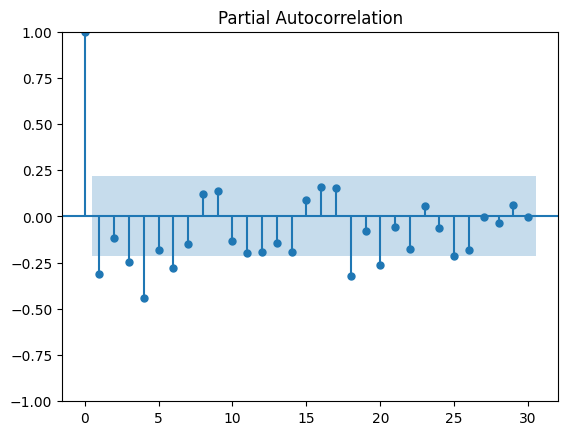

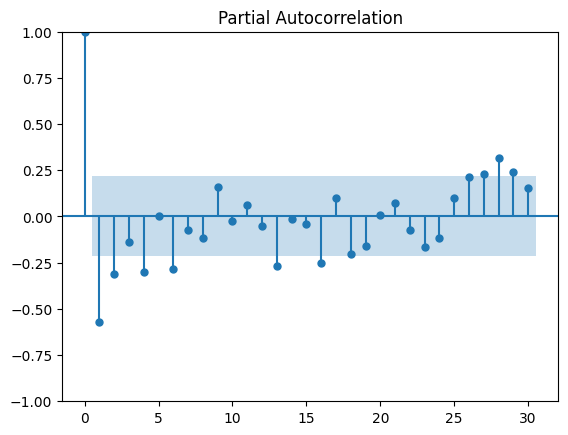

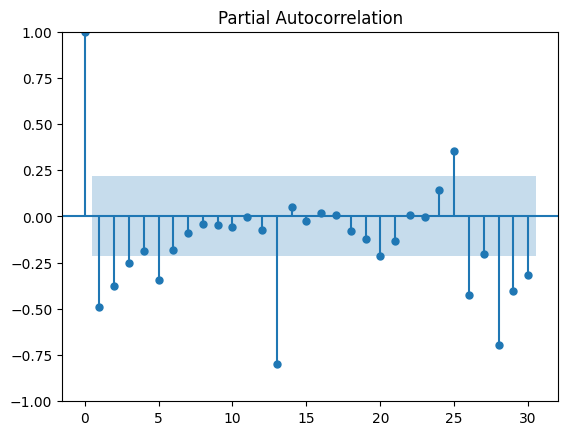

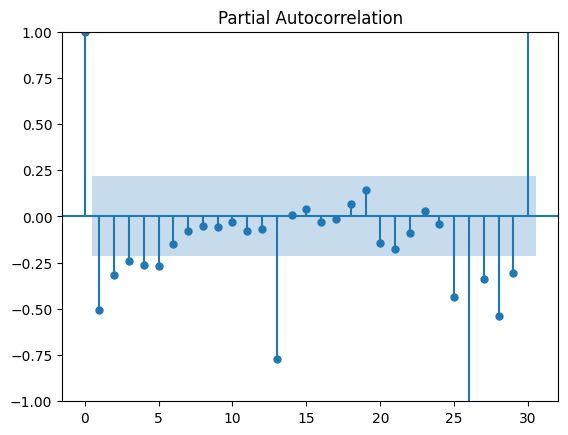

In [8]:
# Determine lags
plot_pacf(merged_df_diff["NEGATIVE_Left-wing"], method = "ols", lags = 30)
plt.show()
## lag 6 

plot_pacf(merged_df_diff["POSITIVE_Right-wing"], method = "ols", lags = 30)
plt.show()

plot_pacf(merged_df_diff["NEGATIVE_Conservative"], method = "ols", lags = 30)
plt.show()

plot_pacf(merged_df_diff["NEGATIVE_Labour"], method = "ols", lags = 30)
plt.show()
## lag 6 

                         NEGATIVE_Centre  NEGATIVE_Left-wing  \
NEGATIVE_Centre                 1.000000            0.553214   
NEGATIVE_Left-wing              0.553214            1.000000   
NEGATIVE_Right-wing             0.673594            0.549120   
POSITIVE_Centre                 0.464308            0.278409   
POSITIVE_Left-wing              0.365778            0.186840   
POSITIVE_Right-wing             0.207286            0.268064   
NEGATIVE_Centre_parties         0.130570            0.144593   
NEGATIVE_Conservative           0.176353            0.220302   
NEGATIVE_Labour                 0.176053            0.173198   
POSITIVE_Centre_parties         0.163348            0.205436   
POSITIVE_Conservative           0.187752            0.203749   
POSITIVE_Labour                 0.130716            0.084272   

                         NEGATIVE_Right-wing  POSITIVE_Centre  \
NEGATIVE_Centre                     0.673594         0.464308   
NEGATIVE_Left-wing                  0

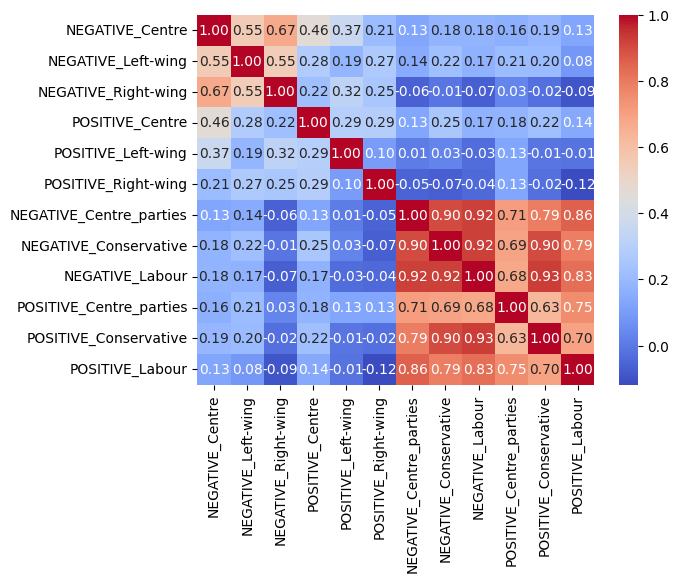

In [9]:
corr_matrix = merged_df.corr()

# Print the correlation matrix
pp(corr_matrix)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show the plot
plt.show()

In [10]:
model = VAR(merged_df_diff)
model_fit = model.fit(maxlags=5, ic="aic")
model_fit.summary()

/home/debian/miniconda3/envs/debates/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     08:42:58
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    33.4994
Nobs:                     77.0000    HQIC:                   20.1303
Log likelihood:          -1010.99    FPE:                6.97885e+07
AIC:                      11.2180    Det(Omega_mle):         63551.2
--------------------------------------------------------------------
Results for equation NEGATIVE_Centre
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.104713         0.454231           -0.231           0.818
L1.NEGATIVE_Centre                -0.026013         0.260978           -0.100           0.92

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# get only significant p-values
model_pvalues = model_fit.pvalues

print(model_pvalues.columns)
print(model_pvalues.shape)

model_pvalues = model_pvalues.melt(value_vars=model_pvalues.columns, var_name = "y_variable", value_name = "pvalue", ignore_index=False)

print(model_pvalues.head())


model_pvalues = model_pvalues[model_pvalues["pvalue"] < 0.05]
#model_pvalues.dropna(how='all', subset=model_pvalues.columns, inplace=True)
model_pvalues.index.name = "x_variable" 

pp(model_pvalues)

model_pvalues.to_csv("varmodel_3_pvalues_winter.csv", index=True)

Index(['NEGATIVE_Centre', 'NEGATIVE_Left-wing', 'NEGATIVE_Right-wing',
       'POSITIVE_Centre', 'POSITIVE_Left-wing', 'POSITIVE_Right-wing',
       'NEGATIVE_Centre_parties', 'NEGATIVE_Conservative', 'NEGATIVE_Labour',
       'POSITIVE_Centre_parties', 'POSITIVE_Conservative', 'POSITIVE_Labour'],
      dtype='object')
(61, 12)
                             y_variable  pvalue
const                   NEGATIVE_Centre   0.818
L1.NEGATIVE_Centre      NEGATIVE_Centre   0.921
L1.NEGATIVE_Left-wing   NEGATIVE_Centre   0.266
L1.NEGATIVE_Right-wing  NEGATIVE_Centre   0.652
L1.POSITIVE_Centre      NEGATIVE_Centre   0.599
                                   y_variable  pvalue
x_variable                                           
L1.NEGATIVE_Left-wing      NEGATIVE_Left-wing   0.049
L5.POSITIVE_Left-wing      NEGATIVE_Left-wing   0.024
L1.NEGATIVE_Centre        NEGATIVE_Right-wing   0.014
L1.NEGATIVE_Right-wing    NEGATIVE_Right-wing   0.029
L2.NEGATIVE_Right-wing    NEGATIVE_Right-wing   0.043
... 

In [12]:
sorted_order=model.select_order(maxlags=5)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       27.76      28.12*   1.135e+12       27.90
1       25.70       30.45   1.514e+11       27.60
2       24.04       33.17   3.698e+10       27.69
3       22.90       36.41   2.480e+10       28.30
4       19.59       37.49   5.182e+09       26.75
5      11.22*       33.50  6.979e+07*      20.13*
-------------------------------------------------


FEVD for NEGATIVE_Centre
     NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  POSITIVE_Centre  POSITIVE_Left-wing  POSITIVE_Right-wing  NEGATIVE_Centre_parties  NEGATIVE_Conservative  NEGATIVE_Labour  POSITIVE_Centre_parties  POSITIVE_Conservative  POSITIVE_Labour
0           1.000000            0.000000             0.000000         0.000000            0.000000             0.000000                 0.000000               0.000000         0.000000                 0.000000               0.000000         0.000000
1           0.603902            0.023828             0.029321         0.022332            0.003415             0.060535                 0.043053               0.000576         0.170991                 0.033481               0.000354         0.008211
2           0.470059            0.015612             0.018119         0.036976            0.048179             0.036945                 0.160677               0.072751         0.107242                 0.020446               0

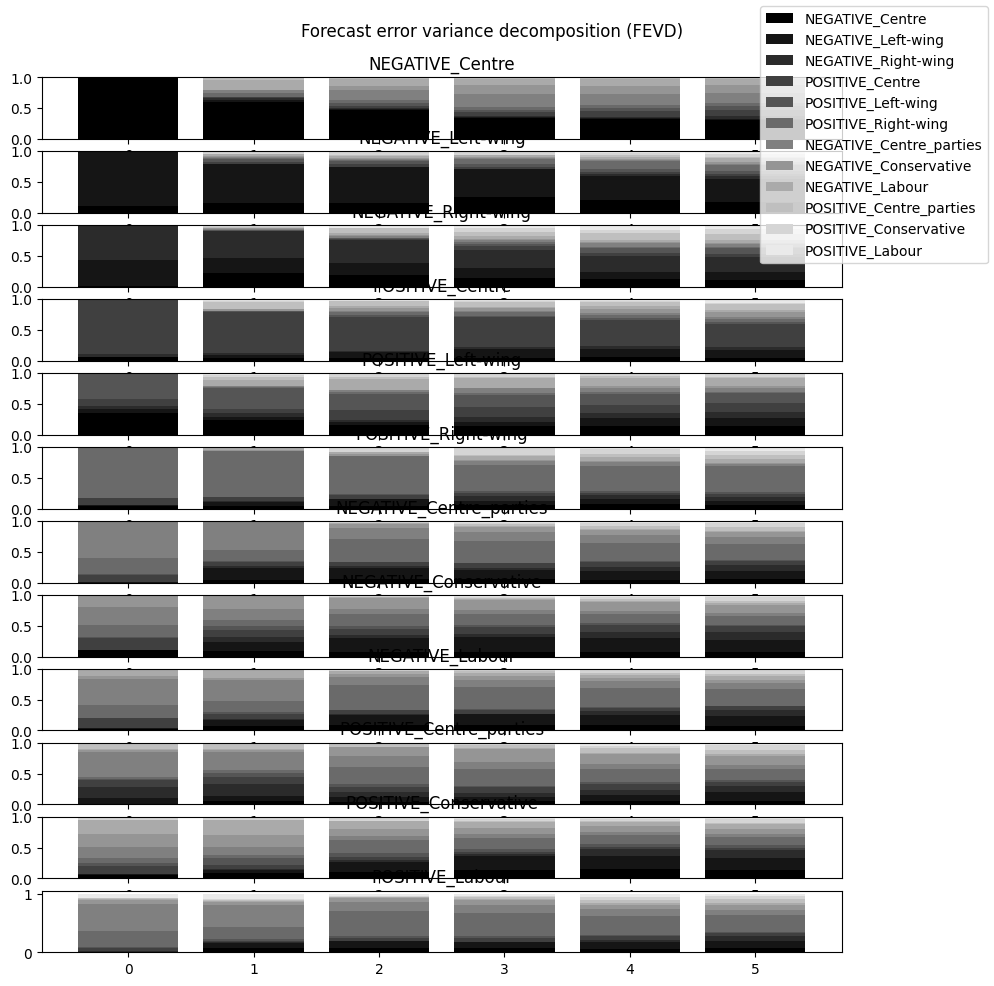

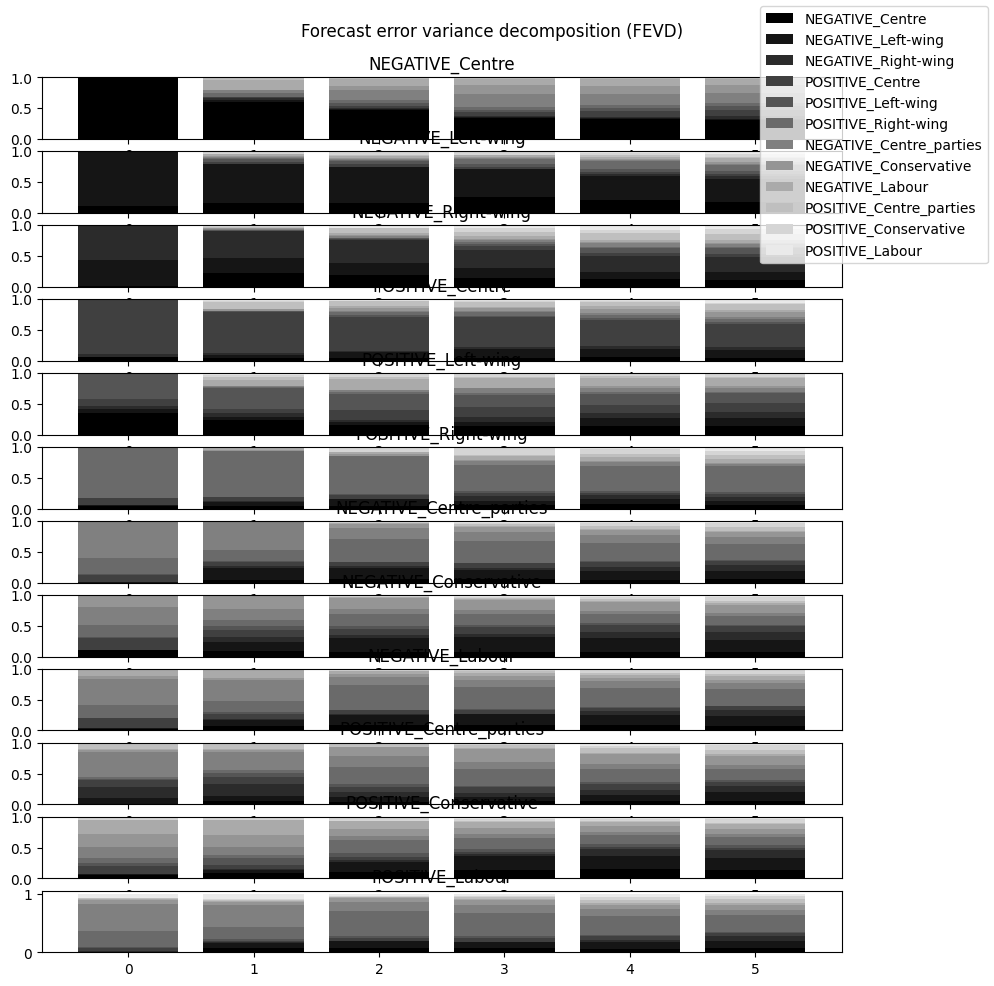

In [13]:
fevd = model_fit.fevd(6)
model_fevd = pd.DataFrame(fevd.summary())

model_fit.fevd(6).plot()

In [14]:
def granger_causality(data, maxlag):
    """
    Performs Granger causality tests for each variable in a dataset using a specified number of lags.

    Args:
    - data: A pandas DataFrame containing the time series data.
    - maxlag: An integer specifying the maximum number of lags to consider in the Granger causality tests.

    Returns:
    - A pandas DataFrame containing the p-values for each pairwise Granger causality test.
    """

    # Initialize an empty DataFrame to store the p-values
    #p_values = pd.DataFrame(columns=data.columns, index=data.columns)
    results: list[dict] = []
    # Loop through each pair of variables and perform a Granger causality test
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            if i != j:
                # Select the two variables to test
                x = data.iloc[:, i]
                y = data.iloc[:, j]

                x_name = data.columns[i]
                y_name = data.columns[j]


                # Run the Granger causality test
                gc_result = grangercausalitytests(np.column_stack((x, y)), maxlag=maxlag, verbose=False)

                # Extract the p-value from the test results for each lag
                #p_values_list = []
                for lag in range(1, maxlag + 1):
                    p_value = gc_result[lag][0]['lrtest'][1]
                    #p_values_list.append(p_value)
                
                # Store the p-values in the DataFrame
                #p_values.iloc[i, j] = str(p_values_list)
                    result = {"x_name":x_name, "y_name":y_name, "lag":lag, "p-value":p_value}

                    results.append(result)

    return pd.DataFrame(results)               


In [15]:
results = granger_causality(merged_df_diff, 5)

print(results)

              x_name                 y_name  lag  p-value
0    NEGATIVE_Centre     NEGATIVE_Left-wing    1    0.012
1    NEGATIVE_Centre     NEGATIVE_Left-wing    2    0.011
2    NEGATIVE_Centre     NEGATIVE_Left-wing    3    0.009
3    NEGATIVE_Centre     NEGATIVE_Left-wing    4    0.024
4    NEGATIVE_Centre     NEGATIVE_Left-wing    5    0.034
..               ...                    ...  ...      ...
655  POSITIVE_Labour  POSITIVE_Conservative    1    0.922
656  POSITIVE_Labour  POSITIVE_Conservative    2    0.822
657  POSITIVE_Labour  POSITIVE_Conservative    3    0.859
658  POSITIVE_Labour  POSITIVE_Conservative    4    0.939
659  POSITIVE_Labour  POSITIVE_Conservative    5    0.678

[660 rows x 4 columns]
